In [21]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pyh5md
from transforms3d import quaternions
import scipy.integrate
import itertools
import tidynamics
from glob import glob
from matplotlib.figure import SubplotParams

π = np.pi

plt.rcParams['figure.figsize'] = (8*.7, 6*.7)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .15
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 14


In [22]:

runs = glob('/path/to/active/l/janus.h5')
runs.sort()
print(len(runs), "runs found")

24 runs found


## Read and analyze simulation data

For every simulation:
1. Compute the "body frame" velocity vB of the L particle
2. Integrate vB to obtain the "body frame" trajectory
3. Compute the cross-displacements and fit the slope to obtain the diffusion matrix

In [23]:
if True:
    all_cdisp = []
    v_mean = []
    all_skip = 2
    for r in runs[:]:
        with pyh5md.File(r, 'r') as a:
            g = a.particles_group('janus')
            pos_0 = pyh5md.element(g, 'position').value[0]
            obs = a['observables']
            janus_pos = pyh5md.element(obs, 'janus_pos')
            janus_pos_dt = janus_pos.time*all_skip
            janus_pos = janus_pos.value[::all_skip]
            janus_vel = pyh5md.element(obs, 'janus_vel')
            janus_vel_dt = janus_vel.time*all_skip
            janus_vel = janus_vel.value[::all_skip]
            omega_body = pyh5md.element(obs, 'omega_body')
            omega_body_dt = omega_body.time*all_skip
            omega_body = omega_body.value[::all_skip]
            q = pyh5md.element(obs, 'q')
            q_qt = q.time*all_skip
            q = q.value[::all_skip]
            u = pyh5md.element(obs, 'u')
            u_dt = u.time*all_skip
            u = u.value[::all_skip]

        tmp_s = q[:,3].copy()
        tmp_v = q[:,:3].copy()
        q[:,1:4] = tmp_v
        q[:,0] = tmp_s
        del tmp_s, tmp_v

        omega = np.array([quaternions.rotate_vector(omega_body_i, q_i) for omega_body_i, q_i in zip(omega_body, q)])

        # transform omega_body with q
        # use it to get omega[1]

        # or

        # get janus_vel
        # transform with inverse quaternion rotation
        # np.sum(..., axis=1) to obtain v1, v2
        idx_1, idx_2 = 5, 35
        d_20_0 = np.sqrt(np.sum((pos_0[idx_2]-pos_0[0])**2))
        d_4_0 = np.sqrt(np.sum((pos_0[idx_1]-pos_0[0])**2))
        u_perp = (pos_0[idx_2,:]-pos_0[0,:])/d_20_0
        u_para = (pos_0[idx_1,:]-pos_0[0,:])/d_4_0

        u_perp = np.array([quaternions.rotate_vector(u_perp, q_i) for q_i in q])
        u_para = np.array([quaternions.rotate_vector(u_para, q_i) for q_i in q])


        v1 = np.array([np.dot(v, u1) for v, u1 in zip(janus_vel, u_perp)])
        v2 = np.array([np.dot(v, u2) for v, u2 in zip(janus_vel, u_para)])

        disp1 = scipy.integrate.cumtrapz(v1)*janus_vel_dt
        disp2 = scipy.integrate.cumtrapz(v2)*janus_vel_dt
        dispt = scipy.integrate.cumtrapz(omega[:,1])*omega_body_dt

        disp_stride = 32
        disp1 = disp1[::disp_stride]
        disp2 = disp2[::disp_stride]
        dispt = dispt[::disp_stride]

        xyz = np.array(list(zip(disp1, disp2, dispt)))
        cdisp = tidynamics.cross_displacement(xyz)

        all_cdisp.append(cdisp)

        v_mean.append((v1.mean(), v2.mean(), omega[:,1].mean()))

    v_mean = np.array(v_mean)

<IPython.core.display.Javascript object>


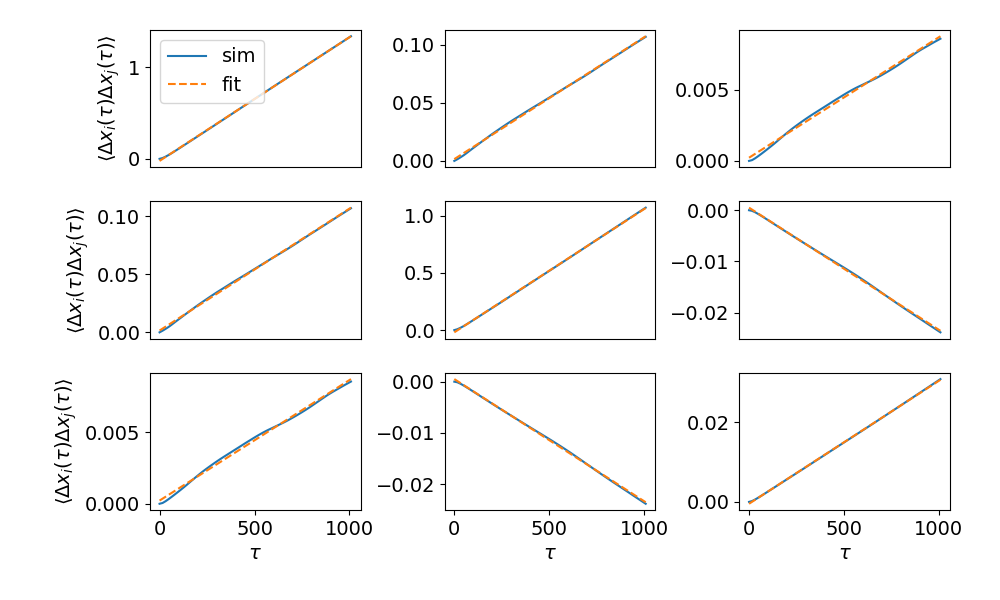

In [24]:
START, STOP = 0, 60

N_disp = 64

disp_time = np.arange(N_disp)*janus_vel_dt*disp_stride

cd = np.mean(all_cdisp, axis=0)
Ddata = np.zeros((3,3))

params = SubplotParams(wspace=0.40, left=.15)
plt.figure(figsize=(10, 6), subplotpars=params)

for i, j in itertools.product(range(3), range(3)):
    plt.subplot(3, 3, 3*i+j+1)

    m = cd[i][j]
    plt.plot(disp_time, m[:N_disp], label='sim')
    fit = np.polyfit(disp_time[START:STOP], m[START:STOP], 1)
    plt.plot(disp_time, np.poly1d(fit)(disp_time), label='fit', ls='--')
    if i==j==0:
        plt.legend()
    Ddata[i, j] = fit[0]/2

    if j==0:
        plt.ylabel(r'$\langle \Delta x_i(\tau) \Delta x_j(\tau) \rangle$')
    if i==2:
        plt.xlabel(r'$\tau$')
        plt.xticks([0, 500, 1000])
    else:
        plt.xticks([])

plt.savefig('L_eq_cross_displacements.pdf')

In [25]:
# print D with LaTeX table formatting
for line in Ddata:
    l1, l2, l3 = map(lambda x: 10000*x, line)
    
    print('%3.2f & %3.2f & %3.2f \\cr' % (l1, l2, l3))


6.77 & 0.52 & 0.04 \cr
0.52 & 5.38 & -0.12 \cr
0.04 & -0.12 & 0.15 \cr


In [26]:
# Compute radius from force and torque

l = 1

X_dot = Ddata @ np.array([1, 0, -l])
print(X_dot)
print(np.sqrt(X_dot[0]**2+X_dot[1]**2)/X_dot[2])

[  6.72368304e-04   6.43873096e-05  -1.12188516e-05]
-60.206179825
